# Human-in-the-Loop AI Defect Classification: Extraction
SEM image data has standardized file output structure. Using the internal defect classification tool, config files are written to slot on which analysis was done, which also have standardized output. Thus, a crawling utility should be able to run on any SEM directory, and output both aggregate defect data and arrays of labeled images. This notebook will serve as a playground for developing base utilities. Once an minimum viable approach is established, I'll move development to python module.


**Extraction Goals:**
* Effectively/repeatably scrape cryptic conf.ini files for defect data
* Develop crawler to spider over SEM files
* Generate standardized dataframe for aggregating scraped data

In [2]:
import os
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image

%matplotlib inline

TESTFILES_PATH = os.path.join(os.getcwd(), '..', 'testing_files')
CONFIG_PATH = os.path.join(TESTFILES_PATH, 'conf.ini')
DATA_PATH = os.path.join(os.getcwd(), '..', 'raw_data')
OUTPUT_PATH = os.path.join(os.getcwd(), '..', 'cleaned_data')
LOT_ROOT = os.path.join('..', 'raw_data', 'l0Q119TeOS12PostHF')

Config file are located in root of each slot's directory, with three file structures with vars `defects`, `map`, and `classes`. First will split up file to extract the data strctures.

In [3]:
def split_file(filepath):
    """ 
    Data cleaning utility to parse defect
    data from SEM .ini files
    
    input
    -----
    filepath: str
        path to .ini file containing data
    
    returns
    -----
    dict:
        'defects': list of images for given defect
        'map': classificaion of each defect
        'classes': key for each classification
        
    """
    file_string = ""

    with open(filepath) as fh:
        for line in fh:
            file_string += line
            
    split_on_list = file_string.split('list = ')
    split_on_map = split_on_list[1].split('map = ')
    split_on_classes = split_on_map[1].split('classes = ')
    
    images = split_on_map[0]
    map = split_on_classes[0]
    classes = split_on_classes[1]
    
    return {'images':images, 'map':map, 'classes':classes}

In [4]:
data = split_file(CONFIG_PATH)
defects = data['images']
defect_map = data['map']
classes = data['classes']

In [5]:
defects

"(dp1\n\tI2\n\t(lp2\n\t(VRun_3\\u005cDefect_2_Class_1_Internal.tiff\n\tS'Internal'\n\tF8\n\tF3500\n\ttp3\n\ta(VRun_3\\u005cDefect_2_Class_1_Topography1.tiff\n\tS'Topography1'\n\tF8\n\tF3500\n\ttp4\n\ta(VRun_3\\u005cDefect_2_Defect_1_Internal.tiff\n\tS'Internal'\n\tF8\n\tF3500\n\ttp5\n\ta(VRun_3\\u005cDefect_2_Defect_1_Topography1.tiff\n\tS'Topography1'\n\tF8\n\tF3500\n\ttp6\n\ta(VRun_6\\u005cDefect_2_Class_1_DUV.tiff\n\tVDUV\n\tNNtp7\n\tasI4\n\t(lp8\n\t(VRun_3\\u005cDefect_4_Class_1_Internal.tiff\n\tS'Internal'\n\tF2\n\tF3500\n\ttp9\n\ta(VRun_3\\u005cDefect_4_Class_1_Topography1.tiff\n\tS'Topography1'\n\tF2\n\tF3500\n\ttp10\n\ta(VRun_3\\u005cDefect_4_Defect_1_Internal.tiff\n\tS'Internal'\n\tF8\n\tF3500\n\ttp11\n\ta(VRun_3\\u005cDefect_4_Defect_1_Topography1.tiff\n\tS'Topography1'\n\tF8\n\tF3500\n\ttp12\n\ta(VRun_6\\u005cDefect_4_Class_1_DUV.tiff\n\tVDUV\n\tNNtp13\n\tasI5\n\t(lp14\n\t(VRun_3\\u005cDefect_5_Class_1_Internal.tiff\n\tS'Internal'\n\tF2\n\tF3500\n\ttp15\n\ta(VRun_3\\u005cDef

In [6]:
defect_map

'(dp1\n\tI2\n\t(lp2\n\tI2\n\taI8248\n\taI-6322\n\taI5\n\tasI4\n\t(lp3\n\tI4\n\taI-3571\n\taI10924\n\taI5\n\tasI5\n\t(lp4\n\tI5\n\taI12357\n\taI-3149\n\taI5\n\tasI6\n\t(lp5\n\tI6\n\taI11045\n\taI8439\n\taI3\n\tasI7\n\t(lp6\n\tI7\n\taI-6229\n\taI-12758\n\taI0\n\tasI8\n\t(lp7\n\tI8\n\taI-14652\n\taI689\n\taI3\n\tasI12\n\t(lp8\n\tI12\n\taI16633\n\taI-1279\n\taI0\n\tasI19\n\t(lp9\n\tI19\n\taI-9048\n\taI-18451\n\taI5\n\tasI23\n\t(lp10\n\tI23\n\taI7106\n\taI21429\n\taI3\n\tasI25\n\t(lp11\n\tI25\n\taI17079\n\taI15105\n\taI0\n\tasI26\n\t(lp12\n\tI26\n\taI-22235\n\taI-4940\n\taI3\n\tasI29\n\t(lp13\n\tI29\n\taI-16530\n\taI16595\n\taI7\n\tasI33\n\t(lp14\n\tI33\n\taI21934\n\taI11468\n\taI3\n\tasI39\n\t(lp15\n\tI39\n\taI-25162\n\taI-5852\n\taI3\n\tasI45\n\t(lp16\n\tI45\n\taI4900\n\taI-27367\n\taI3\n\tasI46\n\t(lp17\n\tI46\n\taI27951\n\taI1332\n\taI5\n\tasI47\n\t(lp18\n\tI47\n\taI28093\n\taI2456\n\taI3\n\tasI50\n\t(lp19\n\tI50\n\taI-9471\n\taI-27572\n\taI0\n\tasI53\n\t(lp20\n\tI53\n\taI-10319\n\taI-2

In [7]:
classes

'(lp1\n\tVPoor Resolution\n\tp2\n\taVNo Defect Visible\n\tp3\n\taVScratches\n\tp4\n\taVParticles\n\tp5\n\taVDents\n\tp6\n\taVProtruding Line\n\tp7\n\taVResidue\n\tp8\n\taVChatter Mark\n\tp9\n\taVCrack\n\tp10\n\ta.\nhighlighted = (lp1\n\t.\n\n'

Pickling output for module testing.

In [8]:
# Generating files for module tests
# with open(os.path.join(TESTFILES_PATH, 'test_classes.pkl'), 'wb') as fh:
#     pickle.dump(classes, fh)

# with open(os.path.join(TESTFILES_PATH, 'test_map.pkl'), 'wb') as fh:
#     pickle.dump(defect_map, fh)

# with open(os.path.join(TESTFILES_PATH, 'test_defects.pkl'), 'wb') as fh:
#     pickle.dump(defects, fh)

Building utility for scraping image file locations, using `split_file`.

In [9]:
def get_image_paths(filepath, dirpath=None):
    """
    Returns cleaned image paths from conf.ini
    file located in each wafers 'Images' directory
    
    input
    -----
    filepath: str
        path to conf.ini file in given wafer's 
        'Image' directory
        
    output
    -----
    list: list of image paths per defect
    
    """
    image_paths = split_file(filepath)['images']
    image_paths_split = re.split("lp", image_paths)[1:]
    clean_image_paths = []
    for defect in image_paths_split:
        images = re.split("a\(V", defect)[1:]
        clean_images = []
        for img in images:
            clean_img = img.split('.tiff')[0]
            clean_img = clean_img.replace('u005c', '') + '.tiff'
            if dirpath:
                clean_img = os.path.join(dirpath, clean_img)
            clean_images.append(clean_img)
#         for image in images:
#             image_w_data = re.split("\n\t", image)[1:]
        clean_image_paths.append(clean_images)
    return clean_image_paths

In [10]:
img_paths = get_image_paths(CONFIG_PATH)
img_paths

[['Run_3\\Defect_2_Class_1_Topography1.tiff',
  'Run_3\\Defect_2_Defect_1_Internal.tiff',
  'Run_3\\Defect_2_Defect_1_Topography1.tiff',
  'Run_6\\Defect_2_Class_1_DUV.tiff'],
 ['Run_3\\Defect_4_Class_1_Topography1.tiff',
  'Run_3\\Defect_4_Defect_1_Internal.tiff',
  'Run_3\\Defect_4_Defect_1_Topography1.tiff',
  'Run_6\\Defect_4_Class_1_DUV.tiff'],
 ['Run_3\\Defect_5_Class_1_Topography1.tiff',
  'Run_3\\Defect_5_Defect_1_Internal.tiff',
  'Run_3\\Defect_5_Defect_1_Topography1.tiff',
  'Run_6\\Defect_5_Class_1_DUV.tiff'],
 ['Run_3\\Defect_6_Class_1_Topography1.tiff',
  'Run_3\\Defect_6_Defect_1_Internal.tiff',
  'Run_3\\Defect_6_Defect_1_Topography1.tiff',
  'Run_6\\Defect_6_Class_1_DUV.tiff'],
 ['Run_3\\Defect_7_Class_1_Topography1.tiff',
  'Run_3\\Defect_7_Defect_1_Internal.tiff',
  'Run_3\\Defect_7_Defect_1_Topography1.tiff',
  'Run_6\\Defect_7_Class_1_DUV.tiff',
  'Run_9\\Defect_7_Class_1_Internal.tiff',
  'Run_9\\Defect_7_Class_1_Topography1.tiff',
  'Run_9\\Defect_7_Defect_1_Inte

Pickling output for module testing.

In [11]:
# Writing test file for module testing
# with open(os.path.join(TESTFILES_PATH, 'test_image_paths.pkl'), 'wb') as fh:
#     pickle.dump(img_paths, fh)

Building utility for scraping defect maps.

In [12]:
def get_defect_map(filepath):
    """
    Returns cleaned defect map from conf.ini
    file located in each wafers 'Images' directory
    
    input
    -----
    filepath: str
        path to conf.ini file in given wafer's 
        'Image' directory
        
    output
    -----
    list: list of data per defect
        ['index', 'defect_id', 'x_coord', \ 
         'y_coord', 'defect_class', 'unknown']
         
    """
    defect_map = split_file(filepath)['map']
    data_per_defect = re.split("\(lp", defect_map)[1:]
    map_per_defect = []
    for defect in data_per_defect:
        map = re.split("\n\t", defect)[:-1]
        map_per_defect.append(map)
    return map_per_defect

In [13]:
clean_defects = get_defect_map(CONFIG_PATH)
clean_defects

[['2', 'I2', 'aI8248', 'aI-6322', 'aI5', 'asI4'],
 ['3', 'I4', 'aI-3571', 'aI10924', 'aI5', 'asI5'],
 ['4', 'I5', 'aI12357', 'aI-3149', 'aI5', 'asI6'],
 ['5', 'I6', 'aI11045', 'aI8439', 'aI3', 'asI7'],
 ['6', 'I7', 'aI-6229', 'aI-12758', 'aI0', 'asI8'],
 ['7', 'I8', 'aI-14652', 'aI689', 'aI3', 'asI12'],
 ['8', 'I12', 'aI16633', 'aI-1279', 'aI0', 'asI19'],
 ['9', 'I19', 'aI-9048', 'aI-18451', 'aI5', 'asI23'],
 ['10', 'I23', 'aI7106', 'aI21429', 'aI3', 'asI25'],
 ['11', 'I25', 'aI17079', 'aI15105', 'aI0', 'asI26'],
 ['12', 'I26', 'aI-22235', 'aI-4940', 'aI3', 'asI29'],
 ['13', 'I29', 'aI-16530', 'aI16595', 'aI7', 'asI33'],
 ['14', 'I33', 'aI21934', 'aI11468', 'aI3', 'asI39'],
 ['15', 'I39', 'aI-25162', 'aI-5852', 'aI3', 'asI45'],
 ['16', 'I45', 'aI4900', 'aI-27367', 'aI3', 'asI46'],
 ['17', 'I46', 'aI27951', 'aI1332', 'aI5', 'asI47'],
 ['18', 'I47', 'aI28093', 'aI2456', 'aI3', 'asI50'],
 ['19', 'I50', 'aI-9471', 'aI-27572', 'aI0', 'asI53'],
 ['20', 'I53', 'aI-10319', 'aI-27876', 'aI5', '

Pickling output for module testing.

In [14]:
# Pickling defect_map
# with open(os.path.join(TESTFILES_PATH, 'cleaned_defect_map.pkl'), 'wb') as fh:
#     pickle.dump(clean_defects, fh)

Notes for map:
* Can split each map to defect on `"\n\t"`
* last defect missing `"as..."`
* Col 1: index
* Col 2: defect ID
* Col 3: X-coord
* Col 4: Y-coord
* Col 5: Defect class - 1 
    * Need to add 1 to match classes!
* Col 6: Unknown

Building utility for scraping defect classes.

In [15]:
def get_defect_label_dict(filepath):
    """
    Returns key of defect classes from conf.ini
    file located in each wafers 'Images' directory
    
    input
    -----
    filepath: str
        path to conf.ini file in given wafer's 
        'Image' directory
        
    output
    -----
    dict 
        key: numeric defect label in defect map
        value: corresponding string defect label
         
    """
    classes = split_file(filepath)['classes']
    clean_classes = {}
    n = 1
    for item in classes.split('\n\t'):
        if 'V' in item:
            clean_classes[n] = (item.split('V')[1])
            n += 1    
    return clean_classes

In [16]:
defect_labels = get_defect_label_dict(CONFIG_PATH)
defect_labels

{1: 'Poor Resolution',
 2: 'No Defect ',
 3: 'Scratches',
 4: 'Particles',
 5: 'Dents',
 6: 'Protruding Line',
 7: 'Residue',
 8: 'Chatter Mark',
 9: 'Crack'}

Pickling output for module testing.

In [17]:
# with open(os.path.join(TESTFILES_PATH, 'test_defect_labels.pkl'), 'wb') as fh:
#     pickle.dump(defect_labels, fh)

Building utility for generating dataframe of defect data, using scraping functions.

In [18]:
def get_defects_df(filepath, lot=None, slot=None, wafer_id=None):
    """
    Returns pandas df from conf.ini
    file located in each wafers 'Images' directory
    
    input
    -----
    filepath: str
        path to conf.ini file in given wafer's 
        'Image' directory
        
    output
    -----
    pandas Dataframe:
        columns = ['index', 'defect_id', 'x_coord', \ 
             'y_coord', 'defect_class', 'unknown']
         
    """
    # TODO: Add column of wafer ID, process cond, wafer count?
    
    clean_defects = get_defect_map(filepath)
    
    defect_df = pd.DataFrame(clean_defects, 
                             columns=['index', 'def_num', 'x', 'y', 'defect', 'unknown'])
    del defect_df['index']
    defect_df['def_num'] = defect_df.def_num.apply(lambda x: x[1:]).astype(int)
    defect_df['x'] = defect_df.x.apply(lambda x: x[2:]).astype(int)
    defect_df['y'] = defect_df.y.apply(lambda x: x[2:]).astype(int)
    #TODO: map class to label
    defect_df['defect'] = defect_df['defect'].apply(lambda x: int(x[2:]) + 1)
    defect_dict = get_defect_label_dict(filepath)
    defect_df['defect_label'] = defect_df['defect'].map(defect_dict)
    
    defect_df['lot'] = [lot] * len(defect_df)
    defect_df['slot'] = [slot] * len(defect_df)
    defect_df['wafer_id'] = [wafer_id] * len(defect_df)
    defect_df['defect_id'] = defect_df['wafer_id'] + '-' + defect_df['def_num'].astype(str)
    
    if slot:
        defect_df['slot'] = defect_df.slot.apply(lambda x: int(x[-2:]))
    #TODO: figure out "unknown"
    del defect_df['unknown']
    
    
    return defect_df

In [19]:
defects_df = get_defects_df(CONFIG_PATH, lot='testlot', slot='2', wafer_id='abc123')
defects_df.head()

,def_num,x,y,defect,defect_label,lot,slot,wafer_id,defect_id
0,2,8248,-6322,6,Protruding Line,testlot,2,abc123,abc123-2
1,4,-3571,10924,6,Protruding Line,testlot,2,abc123,abc123-4
2,5,12357,-3149,6,Protruding Line,testlot,2,abc123,abc123-5
3,6,11045,8439,4,Particles,testlot,2,abc123,abc123-6
4,7,-6229,-12758,1,Poor Resolution,testlot,2,abc123,abc123-7


Pickling output for module testing.

In [20]:
# with open(os.path.join(TESTFILES_PATH, 'test_defects_df.pkl'), 'wb') as fh:
#     pickle.dump(defects_df, fh)

Wondering the distribution of defect labels...

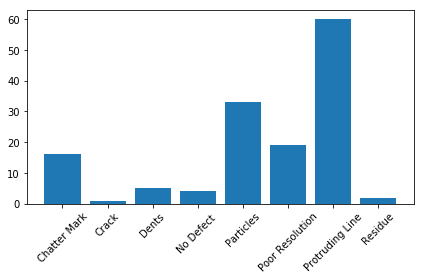

In [21]:
heights = defects_df['defect_label'].value_counts().sort_index()
x = heights.index

plt.bar(x, heights)
plt.xticks(x, rotation=45)
plt.tight_layout();

In [22]:
defects_df.defect_label.value_counts()

Protruding Line    60
Particles          33
Poor Resolution    19
Chatter Mark       16
Dents               5
No Defect           4
Residue             2
Crack               1
Name: defect_label, dtype: int64

Building utility to crawl filestructure for image data and relevant classification output files.

In [23]:
def crawl_lot_directory(root):
    defect_df_list = []
    defect_image_paths = []
    test_img_paths = []

    for dirpath, subdirs, files in os.walk(root):
        if dirpath.endswith('Images'):
           #TODO: Error handling for extensibility to new unlabeled data
        
            lot = dirpath.split('\\')[-4]
            slot = dirpath.split('\\')[-3]
            wafer_id = dirpath.split('\\')[-2]
            
            defect_filepath = os.path.abspath(os.path.join(dirpath, 'conf.ini'))
#             print(defect_filepath)
            # parse defect data
            defect_df = get_defects_df(defect_filepath, lot=lot, slot=slot, wafer_id=wafer_id)
            defect_df_list.append(defect_df)
            # parse images
            image_paths = get_image_paths(defect_filepath, dirpath=dirpath)
            test_img_paths.extend(image_paths)
            
            for d, ss, fs in os.walk(dirpath):
                if not d.endswith('Images'):
                    print('\t%s' % d)
                for f in fs:
                    if f.endswith('.tiff'):
                        # absolute path of image
                        image_loc = os.path.abspath(os.path.join(d, f))
                        print('\t\t%s' % f)
                        defect_image_paths.append(image_loc)
                        
    master_df = pd.concat(defect_df_list).reset_index()
    master_df['image_paths'] = test_img_paths
    return master_df

In [24]:
crawl_df = crawl_lot_directory(LOT_ROOT)

	..\raw_data\l0Q119TeOS12PostHF\wW_02\A6D6F831-A56D-4C53-B94F-8B075D2DBF5C\Images\Run_3
		Defect_103_Class_1_Internal.tiff
		Defect_103_Class_1_Topography1.tiff
		Defect_103_Defect_1_Internal.tiff
		Defect_103_Defect_1_Topography1.tiff
		Defect_105_Class_1_Internal.tiff
		Defect_105_Class_1_Topography1.tiff
		Defect_105_Defect_1_Internal.tiff
		Defect_105_Defect_1_Topography1.tiff
		Defect_106_Class_1_Internal.tiff
		Defect_106_Class_1_Topography1.tiff
		Defect_106_Defect_1_Internal.tiff
		Defect_106_Defect_1_Topography1.tiff
		Defect_110_Class_1_Internal.tiff
		Defect_110_Class_1_Topography1.tiff
		Defect_110_Defect_1_Internal.tiff
		Defect_110_Defect_1_Topography1.tiff
		Defect_111_Class_1_Internal.tiff
		Defect_111_Class_1_Topography1.tiff
		Defect_111_Defect_1_Internal.tiff
		Defect_111_Defect_1_Topography1.tiff
		Defect_113_Class_1_Internal.tiff
		Defect_113_Class_1_Topography1.tiff
		Defect_113_Defect_1_Internal.tiff
		Defect_113_Defect_1_Topography1.tiff
		Defect_114_Class_1_Int

		Defect_7_Defect_1_Internal.tiff
		Defect_7_Defect_1_Topography1.tiff
		Defect_88_Class_1_Internal.tiff
		Defect_88_Class_1_Topography1.tiff
		Defect_88_Defect_1_Internal.tiff
		Defect_88_Defect_1_Topography1.tiff
		Defect_89_Class_1_Internal.tiff
		Defect_89_Class_1_Topography1.tiff
		Defect_89_Defect_1_Internal.tiff
		Defect_89_Defect_1_Topography1.tiff
		Defect_90_Class_1_Internal.tiff
		Defect_90_Class_1_Topography1.tiff
		Defect_90_Defect_1_Internal.tiff
		Defect_90_Defect_1_Topography1.tiff
		Defect_94_Class_1_Internal.tiff
		Defect_94_Class_1_Topography1.tiff
		Defect_94_Defect_1_Internal.tiff
		Defect_94_Defect_1_Topography1.tiff
		Defect_96_Class_1_Internal.tiff
		Defect_96_Class_1_Topography1.tiff
		Defect_96_Defect_1_Internal.tiff
		Defect_96_Defect_1_Topography1.tiff
		Defect_99_Class_1_Internal.tiff
		Defect_99_Class_1_Topography1.tiff
		Defect_99_Defect_1_Internal.tiff
		Defect_99_Defect_1_Topography1.tiff
	..\raw_data\l0Q119TeOS12PostHF\wW_03\6803EED6-FF51-4C71-B014-C80

	..\raw_data\l0Q119TeOS12PostHF\wW_06\DBEA73F5-7FCA-4F09-8EAE-DF961CAE8F12\Images\Run_3
		Defect_105_Class_1_Internal.tiff
		Defect_105_Class_1_Topography1.tiff
		Defect_105_Defect_1_Internal.tiff
		Defect_105_Defect_1_Topography1.tiff
		Defect_109_Class_1_Internal.tiff
		Defect_109_Class_1_Topography1.tiff
		Defect_109_Defect_1_Internal.tiff
		Defect_109_Defect_1_Topography1.tiff
		Defect_115_Class_1_Internal.tiff
		Defect_115_Class_1_Topography1.tiff
		Defect_115_Defect_1_Internal.tiff
		Defect_115_Defect_1_Topography1.tiff
		Defect_119_Class_1_Internal.tiff
		Defect_119_Class_1_Topography1.tiff
		Defect_119_Defect_1_Internal.tiff
		Defect_119_Defect_1_Topography1.tiff
		Defect_138_Class_1_Internal.tiff
		Defect_138_Class_1_Topography1.tiff
		Defect_138_Defect_1_Internal.tiff
		Defect_138_Defect_1_Topography1.tiff
		Defect_141_Class_1_Internal.tiff
		Defect_141_Class_1_Topography1.tiff
		Defect_141_Defect_1_Internal.tiff
		Defect_141_Defect_1_Topography1.tiff
		Defect_143_Class_1_Int

	..\raw_data\l0Q119TeOS12PostHF\wW_07\5E18AA4B-73AE-4093-B26F-3D88A525DDF9\Images\Run_3
		Defect_100_Class_1_Internal.tiff
		Defect_100_Class_1_Topography1.tiff
		Defect_100_Defect_1_Internal.tiff
		Defect_100_Defect_1_Topography1.tiff
		Defect_101_Class_1_Internal.tiff
		Defect_101_Class_1_Topography1.tiff
		Defect_101_Defect_1_Internal.tiff
		Defect_101_Defect_1_Topography1.tiff
		Defect_103_Class_1_Internal.tiff
		Defect_103_Class_1_Topography1.tiff
		Defect_103_Defect_1_Internal.tiff
		Defect_103_Defect_1_Topography1.tiff
		Defect_106_Class_1_Internal.tiff
		Defect_106_Class_1_Topography1.tiff
		Defect_106_Defect_1_Internal.tiff
		Defect_106_Defect_1_Topography1.tiff
		Defect_110_Class_1_Internal.tiff
		Defect_110_Class_1_Topography1.tiff
		Defect_110_Defect_1_Internal.tiff
		Defect_110_Defect_1_Topography1.tiff
		Defect_115_Class_1_Internal.tiff
		Defect_115_Class_1_Topography1.tiff
		Defect_115_Defect_1_Internal.tiff
		Defect_115_Defect_1_Topography1.tiff
		Defect_11_Class_1_Inte

		Defect_188_Defect_1_Internal.tiff
		Defect_188_Defect_1_Topography1.tiff
		Defect_195_Class_1_Internal.tiff
		Defect_195_Class_1_Topography1.tiff
		Defect_195_Defect_1_Internal.tiff
		Defect_195_Defect_1_Topography1.tiff
		Defect_210_Class_1_Internal.tiff
		Defect_210_Class_1_Topography1.tiff
		Defect_210_Defect_1_Internal.tiff
		Defect_210_Defect_1_Topography1.tiff
		Defect_212_Class_1_Internal.tiff
		Defect_212_Class_1_Topography1.tiff
		Defect_212_Defect_1_Internal.tiff
		Defect_212_Defect_1_Topography1.tiff
		Defect_226_Class_1_Internal.tiff
		Defect_226_Class_1_Topography1.tiff
		Defect_226_Defect_1_Internal.tiff
		Defect_226_Defect_1_Topography1.tiff
		Defect_228_Class_1_Internal.tiff
		Defect_228_Class_1_Topography1.tiff
		Defect_228_Defect_1_Internal.tiff
		Defect_228_Defect_1_Topography1.tiff
		Defect_229_Class_1_Internal.tiff
		Defect_229_Class_1_Topography1.tiff
		Defect_229_Defect_1_Internal.tiff
		Defect_229_Defect_1_Topography1.tiff
		Defect_22_Class_1_Internal.tiff
		D

		Defect_267_Defect_1_Internal.tiff
		Defect_267_Defect_1_Topography1.tiff
		Defect_26_Class_1_Internal.tiff
		Defect_26_Class_1_Topography1.tiff
		Defect_26_Defect_1_Internal.tiff
		Defect_26_Defect_1_Topography1.tiff
		Defect_271_Class_1_Internal.tiff
		Defect_271_Class_1_Topography1.tiff
		Defect_271_Defect_1_Internal.tiff
		Defect_271_Defect_1_Topography1.tiff
		Defect_277_Class_1_Internal.tiff
		Defect_277_Class_1_Topography1.tiff
		Defect_277_Defect_1_Internal.tiff
		Defect_277_Defect_1_Topography1.tiff
		Defect_281_Class_1_Internal.tiff
		Defect_281_Class_1_Topography1.tiff
		Defect_281_Defect_1_Internal.tiff
		Defect_281_Defect_1_Topography1.tiff
		Defect_290_Class_1_Internal.tiff
		Defect_290_Class_1_Topography1.tiff
		Defect_290_Defect_1_Internal.tiff
		Defect_290_Defect_1_Topography1.tiff
		Defect_291_Class_1_Internal.tiff
		Defect_291_Class_1_Topography1.tiff
		Defect_291_Defect_1_Internal.tiff
		Defect_291_Defect_1_Topography1.tiff
		Defect_294_Class_1_Internal.tiff
		Defe

	..\raw_data\l0Q119TeOS12PostHF\wW_19\558B0CD4-AA6D-4691-BFAF-5F23B720D67F\Images\Run_3
		Defect_101_Class_1_Internal.tiff
		Defect_101_Class_1_Topography1.tiff
		Defect_101_Defect_1_Internal.tiff
		Defect_101_Defect_1_Topography1.tiff
		Defect_10_Class_1_Internal.tiff
		Defect_10_Class_1_Topography1.tiff
		Defect_10_Defect_1_Internal.tiff
		Defect_10_Defect_1_Topography1.tiff
		Defect_115_Class_1_Internal.tiff
		Defect_115_Class_1_Topography1.tiff
		Defect_115_Defect_1_Internal.tiff
		Defect_115_Defect_1_Topography1.tiff
		Defect_117_Class_1_Internal.tiff
		Defect_117_Class_1_Topography1.tiff
		Defect_117_Defect_1_Internal.tiff
		Defect_117_Defect_1_Topography1.tiff
		Defect_120_Class_1_Internal.tiff
		Defect_120_Class_1_Topography1.tiff
		Defect_120_Defect_1_Internal.tiff
		Defect_120_Defect_1_Topography1.tiff
		Defect_121_Class_1_Internal.tiff
		Defect_121_Class_1_Topography1.tiff
		Defect_121_Defect_1_Internal.tiff
		Defect_121_Defect_1_Topography1.tiff
		Defect_122_Class_1_Interna

	..\raw_data\l0Q119TeOS12PostHF\wW_20\219C0684-8C63-43F9-95F6-583CFE2D947C\Images\Run_3
		Defect_108_Class_1_Internal.tiff
		Defect_108_Class_1_Topography1.tiff
		Defect_108_Defect_1_Internal.tiff
		Defect_108_Defect_1_Topography1.tiff
		Defect_115_Class_1_Internal.tiff
		Defect_115_Class_1_Topography1.tiff
		Defect_115_Defect_1_Internal.tiff
		Defect_115_Defect_1_Topography1.tiff
		Defect_116_Class_1_Internal.tiff
		Defect_116_Class_1_Topography1.tiff
		Defect_116_Defect_1_Internal.tiff
		Defect_116_Defect_1_Topography1.tiff
		Defect_119_Class_1_Internal.tiff
		Defect_119_Class_1_Topography1.tiff
		Defect_119_Defect_1_Internal.tiff
		Defect_119_Defect_1_Topography1.tiff
		Defect_120_Class_1_Internal.tiff
		Defect_120_Class_1_Topography1.tiff
		Defect_120_Defect_1_Internal.tiff
		Defect_120_Defect_1_Topography1.tiff
		Defect_121_Class_1_Internal.tiff
		Defect_121_Class_1_Topography1.tiff
		Defect_121_Defect_1_Internal.tiff
		Defect_121_Defect_1_Topography1.tiff
		Defect_122_Class_1_Int

	..\raw_data\l0Q119TeOS12PostHF\wW_22\9454C73D-D3D8-4271-B3A2-ABB45749D901\Images\Run_3
		Defect_105_Class_1_Internal.tiff
		Defect_105_Class_1_Topography1.tiff
		Defect_105_Defect_1_Internal.tiff
		Defect_105_Defect_1_Topography1.tiff
		Defect_108_Class_1_Internal.tiff
		Defect_108_Class_1_Topography1.tiff
		Defect_108_Defect_1_Internal.tiff
		Defect_108_Defect_1_Topography1.tiff
		Defect_118_Class_1_Internal.tiff
		Defect_118_Class_1_Topography1.tiff
		Defect_118_Defect_1_Internal.tiff
		Defect_118_Defect_1_Topography1.tiff
		Defect_121_Class_1_Internal.tiff
		Defect_121_Class_1_Topography1.tiff
		Defect_121_Defect_1_Internal.tiff
		Defect_121_Defect_1_Topography1.tiff
		Defect_122_Class_1_Internal.tiff
		Defect_122_Class_1_Topography1.tiff
		Defect_122_Defect_1_Internal.tiff
		Defect_122_Defect_1_Topography1.tiff
		Defect_128_Class_1_Internal.tiff
		Defect_128_Class_1_Topography1.tiff
		Defect_128_Defect_1_Internal.tiff
		Defect_128_Defect_1_Topography1.tiff
		Defect_129_Class_1_Int

		Defect_65_Defect_1_Topography1.tiff
		Defect_66_Class_1_Internal.tiff
		Defect_66_Class_1_Topography1.tiff
		Defect_66_Defect_1_Internal.tiff
		Defect_66_Defect_1_Topography1.tiff
		Defect_6_Class_1_Internal.tiff
		Defect_6_Class_1_Topography1.tiff
		Defect_6_Defect_1_Internal.tiff
		Defect_6_Defect_1_Topography1.tiff
		Defect_71_Class_1_Internal.tiff
		Defect_71_Class_1_Topography1.tiff
		Defect_71_Defect_1_Internal.tiff
		Defect_71_Defect_1_Topography1.tiff
		Defect_73_Class_1_Internal.tiff
		Defect_73_Class_1_Topography1.tiff
		Defect_73_Defect_1_Internal.tiff
		Defect_73_Defect_1_Topography1.tiff
		Defect_74_Class_1_Internal.tiff
		Defect_74_Class_1_Topography1.tiff
		Defect_74_Defect_1_Internal.tiff
		Defect_74_Defect_1_Topography1.tiff
		Defect_76_Class_1_Internal.tiff
		Defect_76_Class_1_Topography1.tiff
		Defect_76_Defect_1_Internal.tiff
		Defect_76_Defect_1_Topography1.tiff
		Defect_89_Class_1_Internal.tiff
		Defect_89_Class_1_Topography1.tiff
		Defect_89_Defect_1_Internal.t

	..\raw_data\l0Q119TeOS12PostHF\wW_24\01A2D2A0-A820-4822-A2E2-8E97C920BF91\Images\Run_9
		Defect_170_Class_1_Internal.tiff
		Defect_170_Class_1_Topography1.tiff
		Defect_170_Defect_1_Internal.tiff
		Defect_170_Defect_1_Topography1.tiff
		Defect_220_Class_1_Internal.tiff
		Defect_220_Class_1_Topography1.tiff
		Defect_220_Defect_1_Internal.tiff
		Defect_220_Defect_1_Topography1.tiff
		Defect_225_Class_1_Internal.tiff
		Defect_225_Class_1_Topography1.tiff
		Defect_225_Defect_1_Internal.tiff
		Defect_225_Defect_1_Topography1.tiff
		Defect_228_Class_1_Internal.tiff
		Defect_228_Class_1_Topography1.tiff
		Defect_228_Defect_1_Internal.tiff
		Defect_228_Defect_1_Topography1.tiff
		Defect_258_Class_1_Internal.tiff
		Defect_258_Class_1_Topography1.tiff
		Defect_258_Defect_1_Internal.tiff
		Defect_258_Defect_1_Topography1.tiff
		Defect_405_Class_1_Internal.tiff
		Defect_405_Class_1_Topography1.tiff
		Defect_405_Defect_1_Internal.tiff
		Defect_405_Defect_1_Topography1.tiff
		Defect_503_Class_1_Int

In [25]:
crawl_df.columns

Index(['index', 'def_num', 'x', 'y', 'defect', 'defect_label', 'lot', 'slot',
       'wafer_id', 'defect_id', 'image_paths'],
      dtype='object')

Pickling `crawl_df` for module testing.

In [26]:
# with open(os.path.join(TESTFILES_PATH, 'test_crawl_df.pkl'), 'wb') as fh:
#     pickle.dump(crawl_df, fh)

Notes:
* Dataframe has samples of each *unique defect*. Since the end goal is image classification, dataframe should have samples of each *unique image*. This way I can harness pandas' indexing/sampling as a means for image retrieval. 

Building utility for extending dataframe to have entry for each unique image, based on the dataframe returned from `crawl_lot_directory`.

In [29]:
def create_image_dataframe(crawl_df):
    """
    Return dataframe with defect data for each 
    corresponding defect image filepath
    
    input
    -----
    test_crawler_df: pandas DataFrame
        return from test_crawler()
        
    output
    -----
    pandas DataFrame"""
    data = []

    for i, row in crawl_df.iterrows():
        dup_rows = []
        img_paths = row['image_paths']

        dup_rows = pd.DataFrame([row] * len(img_paths))
        dup_rows['image_paths'] = img_paths
        data.append(dup_rows)

    new_df = pd.concat(data)
    new_df['image_type'] = new_df.image_paths.apply(lambda x: x.split('_')[-1].replace(".tiff", "") \
                                                    + '_' + x.split('_')[-3] + x.split('_')[-2])
    del new_df['index']
    return new_df

In [30]:
image_df = create_image_dataframe(crawl_df)
image_df.head()

,def_num,x,y,defect,defect_label,lot,slot,wafer_id,defect_id,image_paths,image_type
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,..\raw_data\l0Q119TeOS12PostHF\wW_02\A6D6F831-...,Topography1_Class1
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,..\raw_data\l0Q119TeOS12PostHF\wW_02\A6D6F831-...,Internal_Defect1
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,..\raw_data\l0Q119TeOS12PostHF\wW_02\A6D6F831-...,Topography1_Defect1
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,..\raw_data\l0Q119TeOS12PostHF\wW_02\A6D6F831-...,DUV_Class1
1,4,-3571,10924,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-4,..\raw_data\l0Q119TeOS12PostHF\wW_02\A6D6F831-...,Topography1_Class1


Notes:
* This implementation is slow.
* Maybe should add this functionality to the crawler utility

Pickling `image_df` for module testing.

In [182]:
# with open(os.path.join(TESTFILES_PATH, 'test_image_df.pkl'), 'wb') as fh:
#     pickle.dump(image_df, fh)

Building utility that combines the crawler with the image extension utility.

In [35]:
def get_defects_dataframe(root_dir, save_to_path=None):
    
    crawled_df = crawl_lot_directory(root_dir)
    master_df = create_image_dataframe(crawled_df)
    
    if save_to_path != None:
        master_df.to_csv(os.path.join(save_to_path, 'master_defects_df.csv'))
    
    return master_df

In [39]:
image_df = get_defects_dataframe(DATA_PATH, save_to_path=TESTFILES_PATH)

	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS12PostHF\wW_02\A6D6F831-A56D-4C53-B94F-8B075D2DBF5C\Images\Run_3
		Defect_103_Class_1_Internal.tiff
		Defect_103_Class_1_Topography1.tiff
		Defect_103_Defect_1_Internal.tiff
		Defect_103_Defect_1_Topography1.tiff
		Defect_105_Class_1_Internal.tiff
		Defect_105_Class_1_Topography1.tiff
		Defect_105_Defect_1_Internal.tiff
		Defect_105_Defect_1_Topography1.tiff
		Defect_106_Class_1_Internal.tiff
		Defect_106_Class_1_Topography1.tiff
		Defect_106_Defect_1_Internal.tiff
		Defect_106_Defect_1_Topography1.tiff
		Defect_110_Class_1_Internal.tiff
		Defect_110_Class_1_Topography1.tiff
		Defect_110_Defect_1_Internal.tiff
		Defect_110_Defect_1_Topography1.tiff
		Defect_111_Class_1_Internal.tiff
		Defect_111_Class_1_Topography1.tiff
		Defect_111_Defect_1_Internal.tiff
		Defect_111_Defect_1_Topography1.tiff
		Defect_113_Class_1_Internal.tiff
		Defect_113_Class_1_Topography1.tiff
		Defect_113_Defect_1_Internal.tiff
		Defect_113_D

		Defect_379_Defect_1_Topography1.tiff
		Defect_380_Class_1_Internal.tiff
		Defect_380_Class_1_Topography1.tiff
		Defect_380_Defect_1_Internal.tiff
		Defect_380_Defect_1_Topography1.tiff
		Defect_381_Class_1_Internal.tiff
		Defect_381_Class_1_Topography1.tiff
		Defect_381_Defect_1_Internal.tiff
		Defect_381_Defect_1_Topography1.tiff
		Defect_382_Class_1_Internal.tiff
		Defect_382_Class_1_Topography1.tiff
		Defect_382_Defect_1_Internal.tiff
		Defect_382_Defect_1_Topography1.tiff
		Defect_384_Class_1_Internal.tiff
		Defect_384_Class_1_Topography1.tiff
		Defect_384_Defect_1_Internal.tiff
		Defect_384_Defect_1_Topography1.tiff
		Defect_385_Class_1_Internal.tiff
		Defect_385_Class_1_Topography1.tiff
		Defect_385_Defect_1_Internal.tiff
		Defect_385_Defect_1_Topography1.tiff
		Defect_386_Class_1_Internal.tiff
		Defect_386_Class_1_Topography1.tiff
		Defect_386_Defect_1_Internal.tiff
		Defect_386_Defect_1_Topography1.tiff
		Defect_387_Class_1_Internal.tiff
		Defect_387_Class_1_Topography1.tiff


		Defect_571_Class_1_Topography1.tiff
		Defect_571_Defect_1_Internal.tiff
		Defect_571_Defect_1_Topography1.tiff
		Defect_577_Class_1_Internal.tiff
		Defect_577_Class_1_Topography1.tiff
		Defect_577_Defect_1_Internal.tiff
		Defect_577_Defect_1_Topography1.tiff
		Defect_579_Class_1_Internal.tiff
		Defect_579_Class_1_Topography1.tiff
		Defect_579_Defect_1_Internal.tiff
		Defect_579_Defect_1_Topography1.tiff
		Defect_581_Class_1_Internal.tiff
		Defect_581_Class_1_Topography1.tiff
		Defect_581_Defect_1_Internal.tiff
		Defect_581_Defect_1_Topography1.tiff
		Defect_583_Class_1_Internal.tiff
		Defect_583_Class_1_Topography1.tiff
		Defect_583_Defect_1_Internal.tiff
		Defect_583_Defect_1_Topography1.tiff
		Defect_584_Class_1_Internal.tiff
		Defect_584_Class_1_Topography1.tiff
		Defect_584_Defect_1_Internal.tiff
		Defect_584_Defect_1_Topography1.tiff
		Defect_586_Class_1_Internal.tiff
		Defect_586_Class_1_Topography1.tiff
		Defect_586_Defect_1_Internal.tiff
		Defect_586_Defect_1_Topography1.tiff

		Defect_615_Class_1_OM.tiff
		Defect_68_Class_1_OM.tiff
		Defect_80_Class_1_OM.tiff
	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS12PostHF\wW_06\DBEA73F5-7FCA-4F09-8EAE-DF961CAE8F12\Images\Run_9
		Defect_105_Class_1_Internal.tiff
		Defect_105_Class_1_Topography1.tiff
		Defect_105_Defect_1_Internal.tiff
		Defect_105_Defect_1_Topography1.tiff
		Defect_109_Class_1_Internal.tiff
		Defect_109_Class_1_Topography1.tiff
		Defect_109_Defect_1_Internal.tiff
		Defect_109_Defect_1_Topography1.tiff
		Defect_141_Class_1_Internal.tiff
		Defect_141_Class_1_Topography1.tiff
		Defect_141_Defect_1_Internal.tiff
		Defect_141_Defect_1_Topography1.tiff
		Defect_143_Class_1_Internal.tiff
		Defect_143_Class_1_Topography1.tiff
		Defect_143_Defect_1_Internal.tiff
		Defect_143_Defect_1_Topography1.tiff
		Defect_199_Class_1_Internal.tiff
		Defect_199_Class_1_Topography1.tiff
		Defect_199_Defect_1_Internal.tiff
		Defect_199_Defect_1_Topography1.tiff
		Defect_250_Class_1_Internal.tiff
		D

		Defect_316_Class_1_Internal.tiff
		Defect_316_Class_1_Topography1.tiff
		Defect_316_Defect_1_Internal.tiff
		Defect_316_Defect_1_Topography1.tiff
		Defect_319_Class_1_Internal.tiff
		Defect_319_Class_1_Topography1.tiff
		Defect_319_Defect_1_Internal.tiff
		Defect_319_Defect_1_Topography1.tiff
		Defect_31_Class_1_Internal.tiff
		Defect_31_Class_1_Topography1.tiff
		Defect_31_Defect_1_Internal.tiff
		Defect_31_Defect_1_Topography1.tiff
		Defect_323_Class_1_Internal.tiff
		Defect_323_Class_1_Topography1.tiff
		Defect_323_Defect_1_Internal.tiff
		Defect_323_Defect_1_Topography1.tiff
		Defect_324_Class_1_Internal.tiff
		Defect_324_Class_1_Topography1.tiff
		Defect_324_Defect_1_Internal.tiff
		Defect_324_Defect_1_Topography1.tiff
		Defect_326_Class_1_Internal.tiff
		Defect_326_Class_1_Topography1.tiff
		Defect_326_Defect_1_Internal.tiff
		Defect_326_Defect_1_Topography1.tiff
		Defect_330_Class_1_Internal.tiff
		Defect_330_Class_1_Topography1.tiff
		Defect_330_Defect_1_Internal.tiff
		Defec

		Defect_42_Class_1_Internal.tiff
		Defect_42_Class_1_Topography1.tiff
		Defect_42_Defect_1_Internal.tiff
		Defect_42_Defect_1_Topography1.tiff
		Defect_442_Class_1_Internal.tiff
		Defect_442_Class_1_Topography1.tiff
		Defect_442_Defect_1_Internal.tiff
		Defect_442_Defect_1_Topography1.tiff
		Defect_444_Class_1_Internal.tiff
		Defect_444_Class_1_Topography1.tiff
		Defect_444_Defect_1_Internal.tiff
		Defect_444_Defect_1_Topography1.tiff
		Defect_447_Class_1_Internal.tiff
		Defect_447_Class_1_Topography1.tiff
		Defect_447_Defect_1_Internal.tiff
		Defect_447_Defect_1_Topography1.tiff
		Defect_44_Class_1_Internal.tiff
		Defect_44_Class_1_Topography1.tiff
		Defect_44_Defect_1_Internal.tiff
		Defect_44_Defect_1_Topography1.tiff
		Defect_451_Class_1_Internal.tiff
		Defect_451_Class_1_Topography1.tiff
		Defect_451_Defect_1_Internal.tiff
		Defect_451_Defect_1_Topography1.tiff
		Defect_454_Class_1_Internal.tiff
		Defect_454_Class_1_Topography1.tiff
		Defect_454_Defect_1_Internal.tiff
		Defect_45

		Defect_31_Class_1_DUV.tiff
		Defect_34_Class_1_DUV.tiff
		Defect_38_Class_1_DUV.tiff
		Defect_39_Class_1_DUV.tiff
		Defect_3_Class_1_DUV.tiff
		Defect_41_Class_1_DUV.tiff
		Defect_42_Class_1_DUV.tiff
		Defect_43_Class_1_DUV.tiff
		Defect_44_Class_1_DUV.tiff
		Defect_52_Class_1_DUV.tiff
		Defect_54_Class_1_DUV.tiff
		Defect_56_Class_1_DUV.tiff
		Defect_59_Class_1_DUV.tiff
		Defect_5_Class_1_DUV.tiff
		Defect_60_Class_1_DUV.tiff
		Defect_62_Class_1_DUV.tiff
		Defect_69_Class_1_DUV.tiff
		Defect_77_Class_1_DUV.tiff
		Defect_82_Class_1_DUV.tiff
		Defect_83_Class_1_DUV.tiff
		Defect_86_Class_1_DUV.tiff
		Defect_87_Class_1_DUV.tiff
		Defect_8_Class_1_DUV.tiff
		Defect_90_Class_1_DUV.tiff
		Defect_92_Class_1_DUV.tiff
		Defect_93_Class_1_DUV.tiff
		Defect_98_Class_1_DUV.tiff
		Defect_99_Class_1_DUV.tiff
	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS12PostHF\wW_19\558B0CD4-AA6D-4691-BFAF-5F23B720D67F\Images\Run_8
		Defect_122_Class_1_OM.tiff
		Defect_132_Class_1_OM.t

	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS12PostHF\wW_22\9454C73D-D3D8-4271-B3A2-ABB45749D901\Images\Run_3
		Defect_105_Class_1_Internal.tiff
		Defect_105_Class_1_Topography1.tiff
		Defect_105_Defect_1_Internal.tiff
		Defect_105_Defect_1_Topography1.tiff
		Defect_108_Class_1_Internal.tiff
		Defect_108_Class_1_Topography1.tiff
		Defect_108_Defect_1_Internal.tiff
		Defect_108_Defect_1_Topography1.tiff
		Defect_118_Class_1_Internal.tiff
		Defect_118_Class_1_Topography1.tiff
		Defect_118_Defect_1_Internal.tiff
		Defect_118_Defect_1_Topography1.tiff
		Defect_121_Class_1_Internal.tiff
		Defect_121_Class_1_Topography1.tiff
		Defect_121_Defect_1_Internal.tiff
		Defect_121_Defect_1_Topography1.tiff
		Defect_122_Class_1_Internal.tiff
		Defect_122_Class_1_Topography1.tiff
		Defect_122_Defect_1_Internal.tiff
		Defect_122_Defect_1_Topography1.tiff
		Defect_128_Class_1_Internal.tiff
		Defect_128_Class_1_Topography1.tiff
		Defect_128_Defect_1_Internal.tiff
		Defect_128_D

	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS12PostHF\wW_23\E50154FC-2BD1-461B-A8B1-EF52E71D6645\Images\Run_3
		Defect_110_Class_1_Internal.tiff
		Defect_110_Class_1_Topography1.tiff
		Defect_110_Defect_1_Internal.tiff
		Defect_110_Defect_1_Topography1.tiff
		Defect_116_Class_1_Internal.tiff
		Defect_116_Class_1_Topography1.tiff
		Defect_116_Defect_1_Internal.tiff
		Defect_116_Defect_1_Topography1.tiff
		Defect_118_Class_1_Internal.tiff
		Defect_118_Class_1_Topography1.tiff
		Defect_118_Defect_1_Internal.tiff
		Defect_118_Defect_1_Topography1.tiff
		Defect_119_Class_1_Internal.tiff
		Defect_119_Class_1_Topography1.tiff
		Defect_119_Defect_1_Internal.tiff
		Defect_119_Defect_1_Topography1.tiff
		Defect_11_Class_1_Internal.tiff
		Defect_11_Class_1_Topography1.tiff
		Defect_11_Defect_1_Internal.tiff
		Defect_11_Defect_1_Topography1.tiff
		Defect_121_Class_1_Internal.tiff
		Defect_121_Class_1_Topography1.tiff
		Defect_121_Defect_1_Internal.tiff
		Defect_121_Defec

	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS12PostHF\wW_24\01A2D2A0-A820-4822-A2E2-8E97C920BF91\Images\Run_3
		Defect_104_Class_1_Internal.tiff
		Defect_104_Class_1_Topography1.tiff
		Defect_104_Defect_1_Internal.tiff
		Defect_104_Defect_1_Topography1.tiff
		Defect_107_Class_1_Internal.tiff
		Defect_107_Class_1_Topography1.tiff
		Defect_107_Defect_1_Internal.tiff
		Defect_107_Defect_1_Topography1.tiff
		Defect_113_Class_1_Internal.tiff
		Defect_113_Class_1_Topography1.tiff
		Defect_113_Defect_1_Internal.tiff
		Defect_113_Defect_1_Topography1.tiff
		Defect_119_Class_1_Internal.tiff
		Defect_119_Class_1_Topography1.tiff
		Defect_119_Defect_1_Internal.tiff
		Defect_119_Defect_1_Topography1.tiff
		Defect_126_Class_1_Internal.tiff
		Defect_126_Class_1_Topography1.tiff
		Defect_126_Defect_1_Internal.tiff
		Defect_126_Defect_1_Topography1.tiff
		Defect_128_Class_1_Internal.tiff
		Defect_128_Class_1_Topography1.tiff
		Defect_128_Defect_1_Internal.tiff
		Defect_128_D

		Defect_32_Class_1_Internal.tiff
		Defect_32_Class_1_Topography1.tiff
		Defect_32_Defect_1_Internal.tiff
		Defect_32_Defect_1_Topography1.tiff
		Defect_331_Class_1_Internal.tiff
		Defect_331_Class_1_Topography1.tiff
		Defect_331_Defect_1_Internal.tiff
		Defect_331_Defect_1_Topography1.tiff
		Defect_334_Class_1_Internal.tiff
		Defect_334_Class_1_Topography1.tiff
		Defect_334_Defect_1_Internal.tiff
		Defect_334_Defect_1_Topography1.tiff
		Defect_335_Class_1_Internal.tiff
		Defect_335_Class_1_Topography1.tiff
		Defect_335_Defect_1_Internal.tiff
		Defect_335_Defect_1_Topography1.tiff
		Defect_337_Class_1_Internal.tiff
		Defect_337_Class_1_Topography1.tiff
		Defect_337_Defect_1_Internal.tiff
		Defect_337_Defect_1_Topography1.tiff
		Defect_338_Class_1_Internal.tiff
		Defect_338_Class_1_Topography1.tiff
		Defect_338_Defect_1_Internal.tiff
		Defect_338_Defect_1_Topography1.tiff
		Defect_345_Class_1_Internal.tiff
		Defect_345_Class_1_Topography1.tiff
		Defect_345_Defect_1_Internal.tiff
		Defec

		Defect_4722_Class_1_Internal.tiff
		Defect_4722_Class_1_Topography1.tiff
		Defect_4722_Defect_1_Internal.tiff
		Defect_4722_Defect_1_Topography1.tiff
		Defect_4726_Class_1_Internal.tiff
		Defect_4726_Class_1_Topography1.tiff
		Defect_4726_Defect_1_Internal.tiff
		Defect_4726_Defect_1_Topography1.tiff
		Defect_4728_Class_1_Internal.tiff
		Defect_4728_Class_1_Topography1.tiff
		Defect_4728_Defect_1_Internal.tiff
		Defect_4728_Defect_1_Topography1.tiff
		Defect_4760_Class_1_Internal.tiff
		Defect_4760_Class_1_Topography1.tiff
		Defect_4760_Defect_1_Internal.tiff
		Defect_4760_Defect_1_Topography1.tiff
		Defect_4762_Class_1_Internal.tiff
		Defect_4762_Class_1_Topography1.tiff
		Defect_4762_Defect_1_Internal.tiff
		Defect_4762_Defect_1_Topography1.tiff
		Defect_4768_Class_1_Internal.tiff
		Defect_4768_Class_1_Topography1.tiff
		Defect_4768_Defect_1_Internal.tiff
		Defect_4768_Defect_1_Topography1.tiff
		Defect_4776_Class_1_Internal.tiff
		Defect_4776_Class_1_Topography1.tiff
		Defect_4776

	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS13PostHF\wW_04\E4450A94-A53D-4EED-857E-41EC8EEA9955\Images\Run_6
		Defect_111_Class_1_DUV.tiff
		Defect_114_Class_1_DUV.tiff
		Defect_116_Class_1_DUV.tiff
		Defect_118_Class_1_DUV.tiff
		Defect_11_Class_1_DUV.tiff
		Defect_122_Class_1_DUV.tiff
		Defect_124_Class_1_DUV.tiff
		Defect_126_Class_1_DUV.tiff
		Defect_127_Class_1_DUV.tiff
		Defect_12_Class_1_DUV.tiff
		Defect_130_Class_1_DUV.tiff
		Defect_131_Class_1_DUV.tiff
		Defect_132_Class_1_DUV.tiff
		Defect_142_Class_1_DUV.tiff
		Defect_148_Class_1_DUV.tiff
		Defect_155_Class_1_DUV.tiff
		Defect_159_Class_1_DUV.tiff
		Defect_15_Class_1_DUV.tiff
		Defect_162_Class_1_DUV.tiff
		Defect_167_Class_1_DUV.tiff
		Defect_170_Class_1_DUV.tiff
		Defect_171_Class_1_DUV.tiff
		Defect_173_Class_1_DUV.tiff
		Defect_181_Class_1_DUV.tiff
		Defect_183_Class_1_DUV.tiff
		Defect_187_Class_1_DUV.tiff
		Defect_189_Class_1_DUV.tiff
		Defect_198_Class_1_DUV.tiff
		Defect_204_Class_1_DUV.t

	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS13PostHF\wW_07\778E6C38-9626-4D12-96A1-6AEC5FCE8EA8\Images\Run_3
		Defect_104_Class_1_Internal.tiff
		Defect_104_Class_1_Topography1.tiff
		Defect_104_Defect_1_Internal.tiff
		Defect_104_Defect_1_Topography1.tiff
		Defect_108_Class_1_Internal.tiff
		Defect_108_Class_1_Topography1.tiff
		Defect_108_Defect_1_Internal.tiff
		Defect_108_Defect_1_Topography1.tiff
		Defect_116_Class_1_Internal.tiff
		Defect_116_Class_1_Topography1.tiff
		Defect_116_Defect_1_Internal.tiff
		Defect_116_Defect_1_Topography1.tiff
		Defect_119_Class_1_Internal.tiff
		Defect_119_Class_1_Topography1.tiff
		Defect_119_Defect_1_Internal.tiff
		Defect_119_Defect_1_Topography1.tiff
		Defect_136_Class_1_Internal.tiff
		Defect_136_Class_1_Topography1.tiff
		Defect_136_Defect_1_Internal.tiff
		Defect_136_Defect_1_Topography1.tiff
		Defect_140_Class_1_Internal.tiff
		Defect_140_Class_1_Topography1.tiff
		Defect_140_Defect_1_Internal.tiff
		Defect_140_D

	C:\Users\MCopeland155816\Documents\qwe\notebooks\..\raw_data\l0Q119TeOS13PostHF\wW_08\F3187AE5-D5B3-4DE5-8E01-64097DB2CC75\Images\Run_6
		Defect_3389_Class_1_DUV.tiff
		Defect_3390_Class_1_DUV.tiff
		Defect_3392_Class_1_DUV.tiff
		Defect_3396_Class_1_DUV.tiff
		Defect_3400_Class_1_DUV.tiff
		Defect_3403_Class_1_DUV.tiff
		Defect_3409_Class_1_DUV.tiff
		Defect_3412_Class_1_DUV.tiff
		Defect_3418_Class_1_DUV.tiff
		Defect_3421_Class_1_DUV.tiff
		Defect_3440_Class_1_DUV.tiff
		Defect_3451_Class_1_DUV.tiff
		Defect_3479_Class_1_DUV.tiff
		Defect_3480_Class_1_DUV.tiff
		Defect_3494_Class_1_DUV.tiff
		Defect_3499_Class_1_DUV.tiff
		Defect_3502_Class_1_DUV.tiff
		Defect_3510_Class_1_DUV.tiff
		Defect_3514_Class_1_DUV.tiff
		Defect_3516_Class_1_DUV.tiff
		Defect_3527_Class_1_DUV.tiff
		Defect_3562_Class_1_DUV.tiff
		Defect_3566_Class_1_DUV.tiff
		Defect_3571_Class_1_DUV.tiff
		Defect_3576_Class_1_DUV.tiff
		Defect_3587_Class_1_DUV.tiff
		Defect_3588_Class_1_DUV.tiff
		Defect_3589_Class_1_DUV.

In [40]:
image_df.head()

,def_num,x,y,defect,defect_label,lot,slot,wafer_id,defect_id,image_paths,image_type
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Internal_Defect1
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Defect1
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,C:\Users\MCopeland155816\Documents\qwe\noteboo...,DUV_Class1
1,4,-3571,10924,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-4,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1


In [41]:
image_df.shape

(11120, 11)

In [147]:
for im_type in master_df.image_type.unique():
    try: 
        im = Image.open(master_df[master_df.image_type == im_type].image_paths[0])
        print(f'Size of {im_type} images is {im.size}')
    except KeyError:
        print(f'{im_type} not in dataframe')

Size of Topography1_Class1 images is (1000, 1000)
Size of Internal_Defect1 images is (1200, 1200)
Size of Topography1_Defect1 images is (1200, 1200)
Size of DUV_Class1 images is (680, 680)
Internal_Class1 not in dataframe
OM_Class1 not in dataframe


Building utility to open all images in given dataframe, and return to an array of (n_samples, width, height) with the corresponding targets.

In [153]:
def images_to_array(df, image_type='Topography1_Class1', image_resize=(250, 250)):
    """
    Return image arrays from given image_type
    
    input
    ------
    df: pandas DataFrame
        image dataframe
    image_type: str
    
    output
    -----
    tuple: image_array, target_values
    
    """
    dims = {'Topography1_Class1': (1000, 1000),
            'Internal_Defect1': (1200, 1200),
            'Topography1_Defect1': (1200, 1200),
            'DUV_Class1': (680, 680),
            'OM_Class1': (2000, 2000),
            'Internal_Class1': (1000, 1000)}
            
            
    
    im_type_df = df[df.image_type == image_type]
    img_arrays = np.zeros((len(im_type_df), image_resize[0], image_resize[1]))

    for i, row in im_type_df.iterrows():
        path = row.image_paths
        img = Image.open(path).resize(image_resize)
        img_array = np.array(img)
        img_arrays[i] = img_array
    
    return img_arrays, im_type_df

In [154]:
image_arrays, targets = images_to_array(image_df)
len(image_arrays) == len(targets)

True

In [156]:
image_arrays

array([[[121., 101., 110., ...,  44.,  30.,  48.],
        [113., 121., 126., ...,  34.,  39.,  37.],
        [ 90., 102., 103., ...,  31.,  33.,  29.],
        ...,
        [221., 203., 191., ...,  90.,  76.,  95.],
        [199., 183., 225., ...,  78.,  84.,  93.],
        [206., 207., 177., ...,  73.,  72.,  78.]],

       [[128., 115., 106., ...,  81.,  67.,  74.],
        [153., 125.,  90., ...,  91.,  86.,  89.],
        [164., 122., 112., ...,  95.,  61., 122.],
        ...,
        [115., 137., 137., ..., 114., 123., 113.],
        [113., 116., 130., ..., 104., 105., 128.],
        [108., 122., 127., ...,  96.,  98., 102.]],

       [[152., 185., 139., ..., 114.,  79., 116.],
        [120., 147., 110., ...,  58.,  98.,  53.],
        [107., 120., 170., ...,  77.,  97.,  85.],
        ...,
        [178., 125., 134., ..., 117.,  92., 110.],
        [146., 154., 141., ..., 127.,  78.,  97.],
        [116., 144., 175., ..., 122., 104., 105.]],

       ...,

       [[  0.,   0.,   0

Strange. It looks like last few arrays are still in placeholder state.

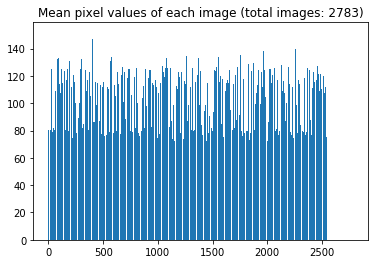

In [157]:
plt.figure()
plt.bar(np.arange(len(image_arrays)), image_arrays.mean(axis=1).mean(axis=1))
plt.title('Mean pixel values of each image (total images: {})'.format(len(targets)));

**Something is off. Last several hundred image arrays are zeros.**

In [158]:
df = image_df
image_type='Topography1_Class1'
image_resize=(250, 250)

im_type_df = df[df.image_type == image_type]
img_arrays = np.zeros((len(im_type_df), image_resize[0], image_resize[1]))

**Are last two hundred raw images blank? Or is there an issue with the array operations?**

Comparing images rendered from directly opening the file (left) and plotting the corresponding array (right)

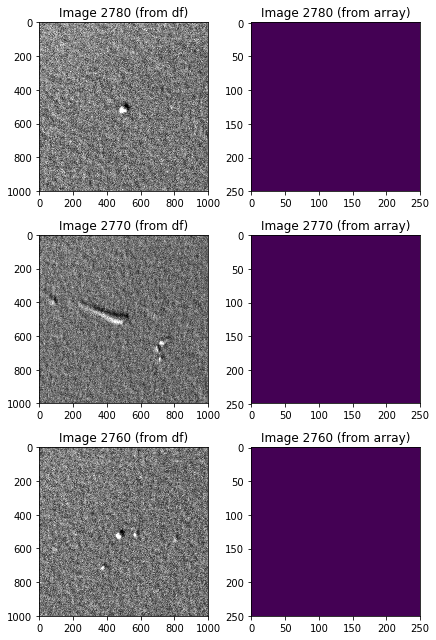

In [174]:
fig, axes = plt.subplots(3, 2, figsize=(6, 9))

n_img = -3
for ax in axes:
    test_path = im_type_df.iloc[n_img, :].image_paths

    im = Image.open(test_path)
    ax[0].imshow(im)
    ax[0].set_title(f'Image {len(im_type_df) + n_img} (from df)')

    im_arr = img_arrays[n_img]
    ax[1].imshow(im_arr)
    ax[1].set_title(f'Image {len(im_type_df) + n_img} (from array)')
    n_img -= 10
plt.tight_layout();

**Array is *not* consistent with targets**

Reproducing the problematic operation...

In [163]:
topo_df = image_df[image_df.image_type == 'Topography1_Class1'] 

image_arrs = np.zeros((len(topo_df), 50, 50))

for i, row in topo_df.iterrows():
    path = row.image_paths
    im = Image.open(path).resize((50, 50))
    image_arrs[i] = np.array(im)

In [167]:
topo_df.head(10)

,def_num,x,y,defect,defect_label,lot,slot,wafer_id,defect_id,image_paths,image_type
0,2,8248,-6322,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-2,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
1,4,-3571,10924,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-4,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
2,5,12357,-3149,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-5,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
3,6,11045,8439,4,Particles,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-6,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
4,7,-6229,-12758,1,Poor Resolution,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-7,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
4,7,-6229,-12758,1,Poor Resolution,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-7,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
5,8,-14652,689,4,Particles,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-8,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
6,12,16633,-1279,1,Poor Resolution,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-12,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
7,19,-9048,-18451,6,Protruding Line,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-19,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1
8,23,7106,21429,4,Particles,l0Q119TeOS12PostHF,2,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C,A6D6F831-A56D-4C53-B94F-8B075D2DBF5C-23,C:\Users\MCopeland155816\Documents\qwe\noteboo...,Topography1_Class1


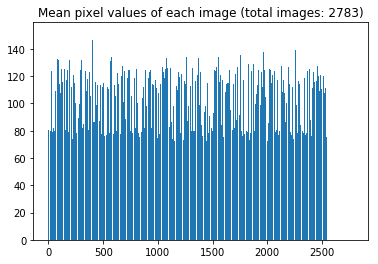

In [164]:
plt.figure()
plt.bar(np.arange(len(image_arrs)), image_arrs.mean(axis=1).mean(axis=1))
plt.title('Mean pixel values of each image (total images: {})'.format(len(targets)));

**Are wafers getting repeated? Seeing repeated indexes** 

In [177]:
topo_df.index.value_counts().unique()

array([2, 1], dtype=int64)

**Solution to Array Mismatch:** Indexes for samples in dataframe are being repeated in parsing of data. Thus, when dataframe index is used to set arrays, samples with duplicate indexes are "rewritten".. thus the arrays are short by the number of duplicate indexes. To verify, will use `.reset_index`

In [170]:
def images_to_array(df, image_type='Topography1_Class1', image_resize=(250, 250)):
    """
    Return image arrays from given image_type
    
    input
    ------
    df: pandas DataFrame
        image dataframe
    image_type: str
    
    output
    -----
    tuple: image_array, target_values
    
    """
    dims = {'Topography1_Class1': (1000, 1000),
            'Internal_Defect1': (1200, 1200),
            'Topography1_Defect1': (1200, 1200),
            'DUV_Class1': (680, 680),
            'OM_Class1': (2000, 2000),
            'Internal_Class1': (1000, 1000)}
            
            
    # Resetting index
    im_type_df = df[df.image_type == image_type].reset_index()
    img_arrays = np.zeros((len(im_type_df), image_resize[0], image_resize[1]))

    for i, row in im_type_df.iterrows():
        path = row.image_paths
        img = Image.open(path).resize(image_resize)
        img_array = np.array(img)
        img_arrays[i] = img_array
    
    return img_arrays, im_type_df

In [171]:
image_arrays, targets = images_to_array(image_df)

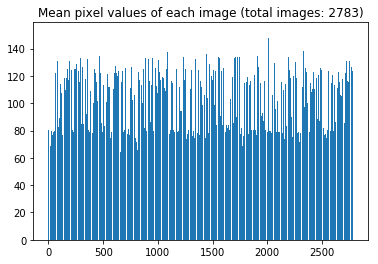

In [172]:
plt.figure()
plt.bar(np.arange(len(image_arrays)), image_arrays.mean(axis=1).mean(axis=1))
plt.title('Mean pixel values of each image (total images: {})'.format(len(targets)));

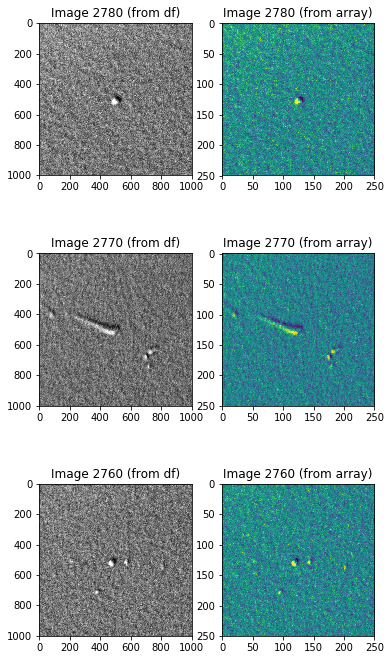

In [173]:
fig, axes = plt.subplots(3, 2, figsize=(6, 12))

n_img = -3
for ax in axes:
    test_path = targets.iloc[n_img, :].image_paths

    im = Image.open(test_path)
    ax[0].imshow(im)
    ax[0].set_title(f'Image {len(im_type_df) + n_img} (from df)')

    im_arr = image_arrays[n_img]
    ax[1].imshow(im_arr)
    ax[1].set_title(f'Image {len(im_type_df) + n_img} (from array)')
    n_img -= 10

**Resetting index of dataframe before writing images to arrays seems to have resolved the problem.**

TODO:
* `images_to_array` should have sampling feature
* Make sure arrays in `images_to_array` has equal index as targets
* Create data-saving module to save to a `cleaned_data` directory
    * If no dataframe exits, create one
    * If one exists, append to it

Saving/pickling data for module testing and data exploration.

In [190]:
# for im_type in image_df.image_type.unique():
#     image_arrays, targets = images_to_array(image_df, image_type=im_type)
#     np.save(os.path.join(OUTPUT_PATH, str(im_type) + '_images'), image_arrays)
#     targets.to_csv(os.path.join(OUTPUT_PATH, str(im_type) + '_targets'))
#     with open(os.path.join(TESTFILES_PATH, 'test_' + str(im_type) + '_arrays'), 'wb') as fh:
#         pickle.dump(image_arrays, fh)
#     with open(os.path.join(TESTFILES_PATH, 'test_' + str(im_type) + '_targets'), 'wb') as fh:
#         pickle.dump(targets, fh)
        

### Notes for data extraction process:
* Run crawl in Lot's directory, not in the `data` dir
* Store data in the `data` dir
    * When running crawl, pass path to datafile
        * If datafile doesn't exist, create one
        * If file exits, append to it

### TODO:
* Crawler will work regardless of running in lot directory or data directory. Need to write data saving utility that will find correct output location regardless.


In [19]:
# TODO: Create dict for lookup of wafer interval
lotslots = ['I0Q119TeOS{0}PostHF-{1}'.format(x, y) for x in range(12, 15) for y in range(1, 25)]

wf_counts = [[100 * x] * 8 for x in range(1, 12)]
wf_counts = [item for sublist in wf_counts for item in sublist]